In [1]:
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt

```% Created by Eugene M. Izhikevich, February 25, 2003

% Excitatory neurons Inhibitory neurons
Ne=800; Ni=200;
re=rand(Ne,1); ri=rand(Ni,1);

a=[0.02*ones(Ne,1); 0.02+0.08*ri];
b=[0.2*ones(Ne,1); 0.25-0.05*ri];
c=[-65+15*re.^2; -65*ones(Ni,1)];
d=[8-6*re.^2; 2*ones(Ni,1)];

S=[0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)];

v=-65*ones(Ne+Ni,1); % Initial values of v
u=b.*v; % Initial values of u

firings=[]; % spike timings

for t=1:1000 % simulation of 1000 ms

    I=[5*randn(Ne,1);2*randn(Ni,1)]; % thalamic input
    
    fired=find(v>=30); % indices of spikes
    firings=[firings; t+0*fired,fired];

    v(fired)=c(fired);
    u(fired)=u(fired)+d(fired);

    I=I+sum(S(:,fired),2);

    v=v+0.5*(0.04*v.^2+5*v+140-u+I); % step 0.5 ms
    v=v+0.5*(0.04*v.^2+5*v+140-u+I); % for numerical

    u=u+a.*(b.*v-u); % stability
end;


Simulación: 1000 ms con dt=1.0 ms
Número total de pasos: 1000
Guardando datos cada 1 pasos
Retrasos: [0] pasos ([0.] ms)
Buffer size: 15 pasos
Simulación completada. Total de disparos: 7013


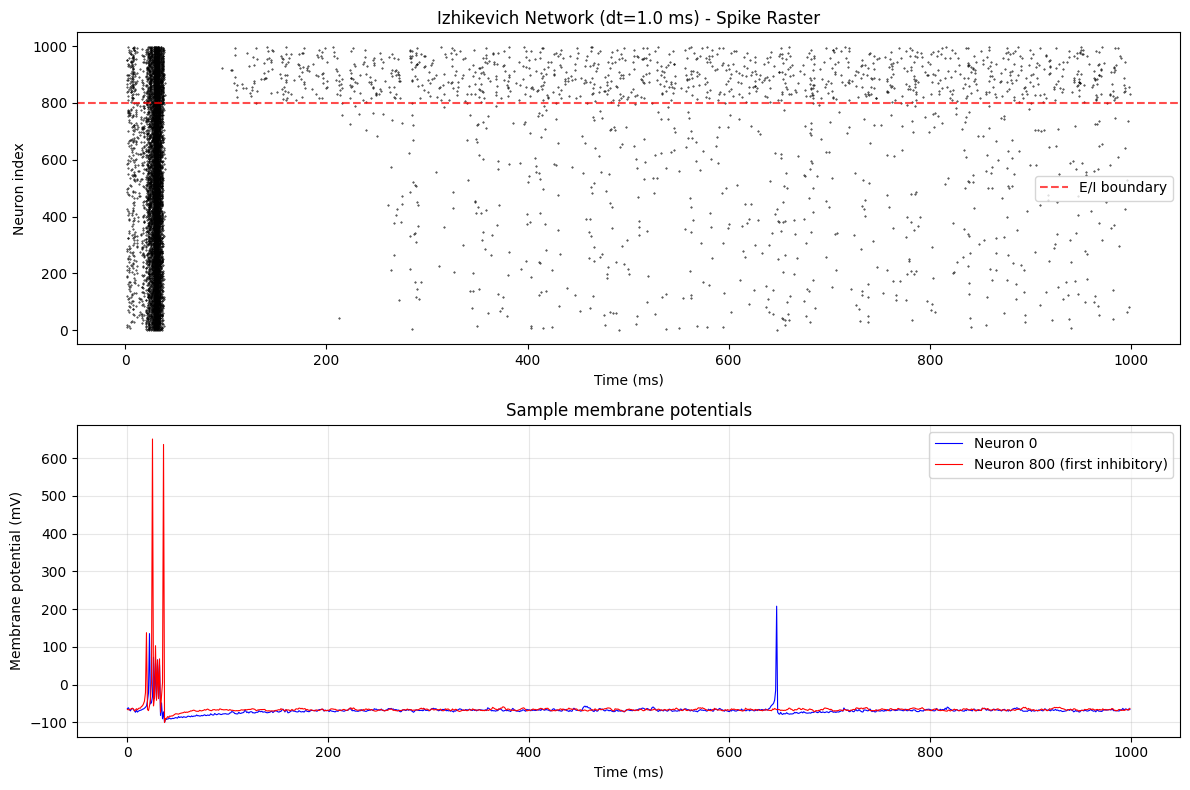

Total spikes: 7013
Spike rate: 7.01 Hz per neuron
Delay range: 0.0 - 0.0 ms
Delay range (steps): 0 - 0 steps


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros temporales
dt = 1.0  # Paso de tiempo en ms
total_time = 1000  # Tiempo total de simulación en ms
n_steps = int(total_time / dt)  # 100,000 pasos
save_every = int(1.0 / dt)  # Guardar datos cada 1 ms (cada 100 pasos)

print(f"Simulación: {total_time} ms con dt={dt} ms")
print(f"Número total de pasos: {n_steps}")
print(f"Guardando datos cada {save_every} pasos")

# Parámetros y condiciones iniciales
np.random.seed(42)

# Definimos Neuronas (1000 - 80% e, 20% i)
Ne = int(800)  # Excitatory neurons
Ni = int(200)  # Inhibitory neurons

# Inicializamos aleatoriamente
re = np.random.rand(Ne)
ri = np.random.rand(Ni)

# Definimos las matrices de parametros para (Excit - Inhib)
a = np.concatenate([0.02*np.ones(Ne), 0.02+0.08*ri])
b = np.concatenate([0.2*np.ones(Ne), 0.25-0.05*ri])
c = np.concatenate([-65+15*re**2, -65*np.ones(Ni)])
d = np.concatenate([8-6*re**2, 2*np.ones(Ni)])

k = 0.5

# Definimos la matriz de acoplamiento (random)
S = np.concatenate([k * np.random.rand(Ne + Ni, Ne), 
                    -2*k*np.random.rand(Ne + Ni, Ni)], axis=1)

# Retrasos sinápticos
max_delay_ms = 15  # Retraso máximo en ms
delays_ms = 0.0 * np.ones((Ne + Ni, Ne + Ni))  # Retrasos en ms

# Convertir retrasos a pasos de tiempo
delays_steps = np.round(delays_ms / dt).astype(int)
max_delay_steps = int(max_delay_ms / dt)

print(f"Retrasos: {np.unique(delays_steps)} pasos ({np.unique(delays_ms)} ms)")
print(f"Buffer size: {max_delay_steps} pasos")

# Buffer para almacenar disparos con retraso
spike_buffer = np.zeros((max_delay_steps, Ne + Ni))

# Condiciones iniciales
v = -65*np.ones(Ne+Ni) + 10*np.random.randn(Ne+Ni)
u = b*v

# Lista de picos
firings = []

# Historiales (guardamos cada 1 ms)
potentials = []
I_thalamic_history = []
I_synaptic_history = []
I_total_history = []

# Simulación con pasos pequeños
for step in range(n_steps):
    t = step * dt  # Tiempo real en ms
    
    # Input talámico (mantener la misma intensidad)
    #I_thalamic = np.concatenate([5 * np.random.randn(Ne), 2 * np.random.randn(Ni)])
    I_thalamic = np.concatenate([1.9 * np.random.poisson(1,Ne), 1.5 * np.random.poisson(1,Ni)])
     
    # Inicializar corriente sináptica
    I_synaptic = np.zeros(Ne + Ni)
    
    # Detectar disparos actuales
    fired = np.where(v >= 30)[0]
    
    if len(fired) > 0:
        # Registrar disparos con tiempo real
        firings.extend([[t, neuron] for neuron in fired])
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        
        # Agregar disparos al buffer con sus respectivos retrasos
        for pre_neuron in fired:
            for post_neuron in range(Ne + Ni):
                if S[post_neuron, pre_neuron] != 0:  # Si hay conexión
                    delay_steps = delays_steps[post_neuron, pre_neuron]
                    if delay_steps == 0:  # Sin retraso - aplicar inmediatamente
                        I_synaptic[post_neuron] += S[post_neuron, pre_neuron]
                    else:  # Con retraso - agregar al buffer
                        delay_idx = (step + delay_steps) % max_delay_steps
                        spike_buffer[int(delay_idx), post_neuron] += S[post_neuron, pre_neuron]
    
    # Aplicar corrientes sinápticas que "llegan" en este momento
    I_synaptic_from_buffer = spike_buffer[step % max_delay_steps, :]
    I_synaptic += I_synaptic_from_buffer
    
    # Limpiar el buffer para el siguiente ciclo
    spike_buffer[step % max_delay_steps, :] = 0
    
    # Corriente total
    I_total = I_thalamic + I_synaptic
    
    # Integración numérica con dt explícito (método de Euler)
    v = v + (dt/2.0) * (0.04 * v**2 + 5 * v + 140 - u + I_total)
    v = v + (dt/2.0) * (0.04 * v**2 + 5 * v + 140 - u + I_total)
    u = u + dt * a * (b * v - u)
    
    # Guardar historiales cada 1 ms (cada save_every pasos)
    if step % save_every == 0:
        potentials.append(v.copy())
        I_thalamic_history.append(I_thalamic.copy())
        I_synaptic_history.append(I_synaptic.copy())
        I_total_history.append(I_total.copy())

print(f"Simulación completada. Total de disparos: {len(firings)}")

# Visualización
if firings:
    firings = np.array(firings)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Raster plot
    ax1.plot(firings[:, 0], firings[:, 1], '.', markersize=0.8, color='black')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Neuron index')
    ax1.set_title(f'Izhikevich Network (dt={dt} ms) - Spike Raster')
    ax1.axhline(y=Ne, color='red', linestyle='--', alpha=0.7, label='E/I boundary')
    ax1.legend()
    
    # Ejemplo de potencial de membrana de una neurona
    if len(potentials) > 0:
        time_points = np.arange(0, len(potentials)) * (save_every * dt)
        potentials_array = np.array(potentials)
        ax2.plot(time_points, potentials_array[:, 0], 'b-', linewidth=0.8, label='Neuron 0')
        ax2.plot(time_points, potentials_array[:, Ne], 'r-', linewidth=0.8, label=f'Neuron {Ne} (first inhibitory)')
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('Membrane potential (mV)')
        ax2.set_title('Sample membrane potentials')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total spikes: {len(firings)}")
    print(f"Spike rate: {len(firings)/(total_time/1000)/(Ne+Ni):.2f} Hz per neuron")
    print(f"Delay range: {np.min(delays_ms)} - {np.max(delays_ms)} ms")
    print(f"Delay range (steps): {np.min(delays_steps)} - {np.max(delays_steps)} steps")
else:
    print("No spikes recorded")

ValueError: x and y must have same first dimension, but have shapes (999,) and (1000,)

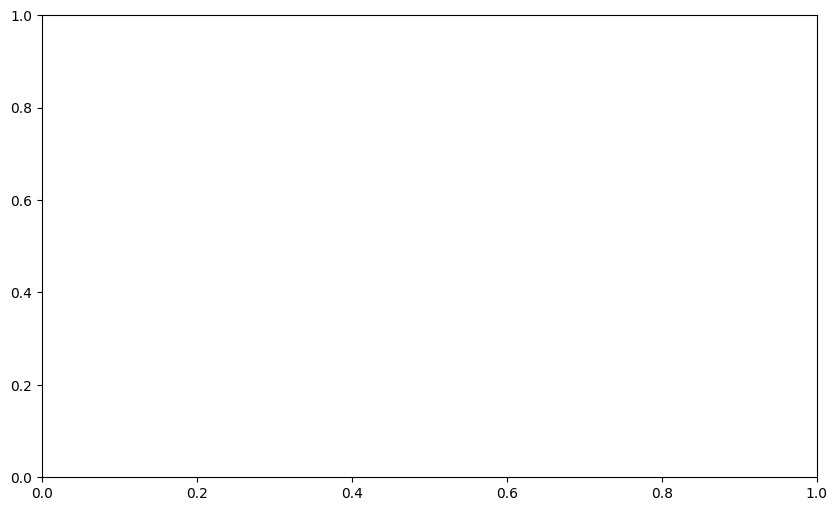

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(range(999), np.array(potentials)[:,10], '--', linewidth=0.3, color = 'black')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.title('Izhikevich Excitatory Neuron')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(999), np.array(potentials)[:,-1], '--', linewidth=0.3, color = 'black')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.title('Izhikevich Inhibitory Neuron')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.title('Distribución de Parámetros (Fig. 2)')
# 3. Distribución de parámetros c,d (como Fig. 2 del paper)
plt.subplot(2, 2, 1)
plt.hist(a[:800], alpha=0.4, color='red', bins= 10, label='Excitatorias a')
plt.hist(b[:800], alpha=0.4, color='blue', bins= 10,label='Excitatorias b')
plt.legend()
plt.subplot(2, 2, 2)
plt.hist(c[:800], alpha=0.4, color='green', bins= 5,label='Excitatorias c')
plt.hist(d[:800], alpha=0.4, color='orange', bins= 5,label='Excitatorias d')

plt.subplot(2, 2, 3)
plt.hist(a[800:], alpha=0.4, color='red', bins= 10,label='Inhibitorias a')
plt.hist(b[800:], alpha=0.4, color='blue', bins= 10,label='Inhibitorias b')
plt.subplot(2, 2, 4)
plt.hist(c[800:], alpha=0.4, color='green', bins= 2,label='Inhibitorias c')
plt.hist(d[800:], alpha=0.4, color='orange', bins= 2,label='Inhibitorias d')


plt.legend()

In [ ]:
plt.figure(figsize=(8, 6))
# 4. Histograma de frecuencias
plt.subplot(1,1,1)
freq_exc = []
freq_inh = []

for i in range(0,Ne):
    spike_count = sum(firings[:,1]==i)
    freq_exc.append(spike_count)

for i in range(Ne,Ne+Ni):
    spike_count = sum(firings[:,1]==i) 
    freq_inh.append(spike_count)

plt.hist(freq_exc, bins=30, alpha=0.7, density=True, label='Excitatorias')
plt.hist(freq_inh, bins=30, alpha=0.7, density=True, label='Inhibitorias')
plt.xlabel('Spikes en 1000ms')
plt.ylabel('Densidad')
plt.title('Distribución de Actividad')
plt.legend()

In [ ]:
# Análisis adicional para comparar con Brian2
# Actividad poblacional
bin_size = 5  # ms
time_bins = np.arange(0, 1000, bin_size)
activity = []
for t in time_bins:
    spikes_in_bin = np.sum((firings[:, 0] >= t) & (firings[:, 0] < t + bin_size))
    activity.append(spikes_in_bin)

plt.figure(figsize=(8, 6))

# Actividad de red
plt.subplot(1, 1, 1)
plt.plot(time_bins, activity, 'k-', linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel(f'Spikes/{bin_size}ms')
plt.title('Network Activity')

In [ ]:
# Análisis espectral
plt.subplot(1, 1, 1)
from scipy import signal
freqs, psd = signal.periodogram(activity, fs=1000/bin_size)
alpha_band = (freqs >= 8) & (freqs <= 12)
gamma_band = (freqs >= 30) & (freqs <= 50)

plt.plot(freqs, psd, 'k-', alpha=0.5)
plt.plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alpha')
plt.plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xlim(0, 100)
plt.legend()


In [ ]:
# Comparar distribuciones de pesos
print("Python S excitatorio:", np.mean(S[:, :800]), np.std(S[:, :800]))
print("Python S inhibitorio:", np.mean(S[:, 800:]), np.std(S[:, 800:]))

In [ ]:
# Convertir listas a arrays
I_thalamic_matlab = np.array(I_thalamic_history)  # (1000, 1000)
I_synaptic_matlab = np.array(I_synaptic_history)  # (1000, 1000)
I_total_matlab = np.array(I_total_history)        # (1000, 1000)

# Separar excitatorias e inhibitorias
I_thal_exc_matlab = I_thalamic_matlab[:, :800]    # (1000, 800)
I_thal_inh_matlab = I_thalamic_matlab[:, 800:]    # (1000, 200)
I_syn_exc_matlab = I_synaptic_matlab[:, :800]     # (1000, 800)
I_syn_inh_matlab = I_synaptic_matlab[:, 800:]     # (1000, 200)
I_tot_exc_matlab = I_total_matlab[:, :800]        # (1000, 800)
I_tot_inh_matlab = I_total_matlab[:, 800:]        # (1000, 200)

# Estadísticas MATLAB
stats_matlab = {
    'thalamic_exc': {
        'mean_per_neuron': np.mean(I_thal_exc_matlab, axis=0),  # Media temporal por neurona
        'std_per_neuron': np.std(I_thal_exc_matlab, axis=0),    # Std temporal por neurona
        'mean_per_timestep': np.mean(I_thal_exc_matlab, axis=1), # Media poblacional por timestep
        'min_per_timestep': np.min(I_thal_exc_matlab, axis=1),
        'max_per_timestep': np.max(I_thal_exc_matlab, axis=1)
    },
    'synaptic_exc': {
        'mean_per_neuron': np.mean(I_syn_exc_matlab, axis=0),
        'std_per_neuron': np.std(I_syn_exc_matlab, axis=0),
        'mean_per_timestep': np.mean(I_syn_exc_matlab, axis=1),
        'min_per_timestep': np.min(I_syn_exc_matlab, axis=1),
        'max_per_timestep': np.max(I_syn_exc_matlab, axis=1)
    },
    'total_exc': {
        'mean_per_neuron': np.mean(I_tot_exc_matlab, axis=0),
        'std_per_neuron': np.std(I_tot_exc_matlab, axis=0),
        'mean_per_timestep': np.mean(I_tot_exc_matlab, axis=1),
        'min_per_timestep': np.min(I_tot_exc_matlab, axis=1),
        'max_per_timestep': np.max(I_tot_exc_matlab, axis=1)
    },
    'thalamic_inh': {
        'mean_per_neuron': np.mean(I_thal_inh_matlab, axis=0),  # Media temporal por neurona
        'std_per_neuron': np.std(I_thal_inh_matlab, axis=0),    # Std temporal por neurona
        'mean_per_timestep': np.mean(I_thal_inh_matlab, axis=1), # Media poblacional por timestep
        'min_per_timestep': np.min(I_thal_inh_matlab, axis=1),
        'max_per_timestep': np.max(I_thal_inh_matlab, axis=1)
    },
    'synaptic_inh': {
        'mean_per_neuron': np.mean(I_syn_inh_matlab, axis=0),
        'std_per_neuron': np.std(I_syn_inh_matlab, axis=0),
        'mean_per_timestep': np.mean(I_syn_inh_matlab, axis=1),
        'min_per_timestep': np.min(I_syn_inh_matlab, axis=1),
        'max_per_timestep': np.max(I_syn_inh_matlab, axis=1)
    },
    'total_inh': {
        'mean_per_neuron': np.mean(I_tot_inh_matlab, axis=0),
        'std_per_neuron': np.std(I_tot_inh_matlab, axis=0),
        'mean_per_timestep': np.mean(I_tot_inh_matlab, axis=1),
        'min_per_timestep': np.min(I_tot_inh_matlab, axis=1),
        'max_per_timestep': np.max(I_tot_inh_matlab, axis=1)
    }
}

In [ ]:
# Comparar medias
print("=== INPUT TALÁMICO ===")
print(f"MATLAB exc - Media por neurona: {np.mean(stats_matlab['thalamic_exc']['mean_per_neuron']):.4f}")

print(f"MATLAB exc - Std por neurona: {np.mean(stats_matlab['thalamic_exc']['std_per_neuron']):.4f}")


print("\n=== INPUT SINÁPTICO ===")
print(f"MATLAB exc - Media: {np.mean(stats_matlab['synaptic_exc']['mean_per_neuron']):.4f}")

print(f"MATLAB exc - Std: {np.mean(stats_matlab['synaptic_exc']['std_per_neuron']):.4f}")


# Rangos de variación
print(f"MATLAB exc - Rango típico: [{np.mean(stats_matlab['synaptic_exc']['min_per_timestep']):.2f}, {np.mean(stats_matlab['synaptic_exc']['max_per_timestep']):.2f}]")


In [ ]:
# Python original - contar spikes por timestep
print("Python spikes/ms:", np.mean(firings[:,0]), np.max(firings[:,0]))
